In [ ]:
import glob

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from astropy.io import fits

from scipy.optimize import curve_fit
from scipy.optimize import minimize
from scipy.ndimage import gaussian_filter1d

import celerite2
from celerite2 import terms


wavlabel = r"Wavelength [$\AA$]"
adulabel = "Flux [ADU]"

def fit_gp(x, maskedx, maskedy, maskedyerr):
    """GP fit to the data. 

    Parameters
    ----------
    x : array
        Wavelength array (including the region we want to predict)
    maskedx : array
        Wavelength array (excluding the region we want to predict)
    maskedy : array
        Flux array (excluding the region we want to predict)
    maskedyerr : array
        Flux error array (excluding the region we want to predict)

    Returns
    -------
    mu : array
        Mean of the GP prediction
    variance : array
        Variance of the GP prediction
    """

    # setup the kernel:

    # Quasi-periodic term
    term1 = terms.SHOTerm(sigma=1.0, rho=1.0, tau=10.0)

    # Non-periodic component
    term2 = terms.SHOTerm(sigma=1.0, rho=5.0, Q=0.25)
    kernel = term1 + term2

    # Setup the GP
    gp = celerite2.GaussianProcess(kernel, mean=0.0)
    gp.compute(maskedx, yerr=maskedyerr)

    print("Initial log likelihood: {0}".format(gp.log_likelihood(maskedy)))

    # Plot the initial prediction
    def plot_prediction(gp):
        plt.errorbar(maskedx, maskedy, yerr=maskedyerr, fmt=".k", capsize=0, label="truth")

        if gp:
            mu, variance = gp.predict(maskedy, t=x, return_var=True)
            sigma = np.sqrt(variance)
            plt.plot(x, mu, label="prediction")
            plt.fill_between(x, mu - sigma, mu + sigma, color="C0", alpha=0.2)

            return mu, variance

    plt.title("Initial prediction")
    plot_prediction(gp)

    # log likelihood fit 

    def set_params(params, gp):
        gp.mean = params[0]
        theta = np.exp(params[1:])
        gp.kernel = terms.SHOTerm(
            sigma=theta[0], rho=theta[1], tau=theta[2]
        ) + terms.SHOTerm(sigma=theta[3], rho=theta[4], Q=0.25)
        gp.compute(maskedx, diag=maskedyerr**2 + theta[5], quiet=True)
        return gp


    def neg_log_like(params, gp):
        gp = set_params(params, gp)
        return -gp.log_likelihood(maskedy)


    initial_params = [0.0, 0.0, 0.0, np.log(10.0), 0.0, np.log(5.0), np.log(0.01)]
    soln = minimize(neg_log_like, initial_params, method="L-BFGS-B", args=(gp,))
    opt_gp = set_params(soln.x, gp)
    
    plt.figure()
    plt.title("maximum likelihood prediction")
    return plot_prediction(opt_gp)


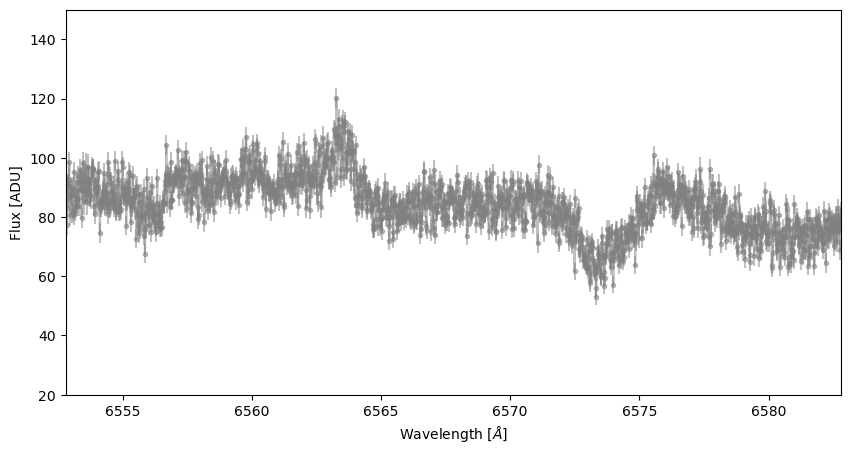

In [ ]:
if __name__ == "__main__":

    # find all file names
    files = glob.glob('spectra/*RED_SCI_POINT*.fits')

    # sort files by date
    files.sort()
    files = files[::-1]

    # make sure all files are there
    assert len(files) == 8

    # READ IN THE DATA ----------------------------------------------------------------
    data, errors, timestamps = [], [], []
    for f in files:

        # get the time stamp
        timestamps.append(f[-17:-12])

        # find the corresponding error file
        errfile = f.replace("RED_SCI_POINT", "ERRORBAR_SCI_POINT")

        # read the wavelength file, but it's the same for all files
        with fits.open(f) as hdul:
            data.append(hdul[0].data)
            wavs = np.array([hdul[0].header["CRVAL1"] + hdul[0].header["CDELT1"] * i 
                            for i in range(len(hdul[0].data))])        

        # read the error file
        with fits.open(errfile) as hdul:
            errors.append(hdul[0].data)

    # convert to numpy array
    data = np.array(data)

    # coadd the spectra
    coadd = np.median(data, axis=0)

    # coadd the error quadratically
    error = np.sqrt(np.sum(np.array(errors)**2, axis=0)) / len(errors)

    # DEFINE THE MASKS and THRESHOLDS -------------------------------------------------

    minrange, maxrange = 6562.8 - 10, 6562.8 + 20
    minhalpharange, maxhalpharange = 6562.8 - 1.2, 6562.8 + 1.2
    mincairange, maxcairange = 6564, 6589
    sigma_thresh = 3
    wavcai = 6572.8 # wavelength of the Ca I line


    # DIAGNOSTIC PLOT -- COADDED SPECTRUM ----------------------------------------------
    # plot the coadded spectrum
    plt.figure(figsize=(10, 5))
    plt.errorbar(wavs, coadd, yerr=error, fmt='.-', alpha=0.5, c="grey")
    plt.xlim(minrange, maxrange)
    plt.ylim(20, 150)
    plt.xlabel(wavlabel)
    plt.ylabel(adulabel)
    plt.tight_layout()
    plt.savefig("figures/bri_raw_coadded_spectrum.png", dpi=300)

    # mask the region around the H alpha line and interpolate the continuum\
    x = np.copy(wavs)
    mask = (wavs > mincairange) & (wavs < maxcairange)
    x, y, yerr = wavs[mask], coadd[mask] / np.median(coadd[mask]), error[mask] /  np.median(coadd[mask])
    caimask = (x > 6571) & (x < 6576)
    maskedx, maskedy, maskedyerr = x[~caimask], y[~caimask], yerr[~caimask]

    # fit the GP
    mucai, varcai = fit_gp(x, maskedx, maskedy, maskedyerr)


    # MEASURE THE SPECTRUM WAVELENGTH OFFSET ----------------------------------------------

    # identify the line center of the Ca I line at nomimally 6572.78 AA
    line_centers = []

    # use only region around Ca I line for fitting a gaussian
    mask = (wavs > mincairange) & (wavs < maxcairange)
    x = wavs[mask]
    y = coadd[mask] / np.median(coadd[mask]) - mucai
    yerr = error[mask] / np.median(coadd[mask])

    # fit an inverted gaussian with an offset to the Ca I line
    def gauss(x, a, x0, sigma, offset):
        return a * np.exp(-(x - x0)**2 / (2 * sigma**2)) + offset

    # a plot the result
    plt.figure(figsize=(8, 4))
    plt.errorbar(x, y, yerr =yerr, label='data', c="grey", fmt=".-", alpha=0.5, zorder=-10)

    # use different cut offs to get a better estimate of the line center
    for i in range(20):

        # define the region to fit to
        mask = (x > 6571 - i/4) & (x < 6576 + i/4)

        nx = x[mask]
        ny = y[mask] 
        nyerr = yerr[mask]

        # fit an inverted gaussian with an offset to the Ca I line around 6573
        popt, pcov = curve_fit(gauss, nx, -ny, absolute_sigma=np.mean(nyerr), p0=[-100, 6573, 1, 0])

        # plot the result
        plt.plot(nx, -gauss(nx, *popt), label='fit', alpha=0.5, c="red")

        # store the line center
        line_centers.append(popt[1])

    # layout the diagnostic plot
    plt.xlim(mincairange, maxcairange)
    plt.xlabel(wavlabel)
    plt.ylabel(adulabel)
    plt.tight_layout()
    plt.savefig("figures/bri_caI_line_fit.png", dpi=300)

    # get mean and std of fitted line center
    m_caI, std_caI = np.mean(line_centers), np.std(line_centers)

    # calculate the offset
    offset = m_caI - wavcai

    print(f"Ca I line center is offset by: {offset:.3f} +/- {std_caI:.3f} AA")

    # OFFSET THE SPECTRUM -----------------------------------------------------------

    # new wavelengths
    nwavs = wavs - offset

    # now use only the region around the H alpha line 6562.8
    mask = (nwavs > minrange) & (nwavs < maxrange)

    x = nwavs[mask]
    y = coadd[mask] / np.median(coadd[mask])
    yerr = error[mask] / np.median(coadd[mask])

    # diagnostic plot   
    plt.figure(figsize=(8, 4))
    plt.errorbar(x, y, yerr=yerr, fmt='.-', alpha=0.5, c="grey")
    plt.axvline(6562.8, color='r', ls='--', label='rest frame')
    plt.xlabel(wavlabel)
    plt.ylabel("Normalized flux")
    plt.xlim(minrange, maxrange)
    plt.tight_layout()
    plt.savefig("figures/bri_shifted_coadded_spectrum.png", dpi=300)

    # GP FIT THE CONTINUUM UNDER THE H ALPHA LINE --------------------------------

    # mask the region around the H alpha line 
    mask = (x > minhalpharange) & (x < maxhalpharange)
    maskedx, maskedy, maskedyerr = x[~mask], y[~mask], yerr[~mask]

    # GP fit the continuum
    mu, var = fit_gp(x, maskedx, maskedy, maskedyerr)

    # SUBTRACT THE CONTINUUM ------------------------------------------------------

    # init the subtracted spectra
    nspecs, newerrs = [], []

    # the final spectrum is in the defined range
    mask = (nwavs > minrange) & (nwavs < maxrange)
    nnwavs = nwavs[mask]

    # mask out the H alpha line where you want to subtract the continuum from
    hamask =  ~((nnwavs > minhalpharange) & (nnwavs < maxhalpharange))

    # loop over all spectra
    for spectrum, err in list(zip(data, errors)):

        # mask the region around the H alpha line 
        ms = spectrum[mask]
        mms = spectrum[mask][hamask]
        mus = mu[hamask]

        # scale mu to the spectrum by using a constant factor
        def func(factor):
            return np.sum((mms - factor * mus)**2)
        
        # minimize the difference between the spectrum and the mu
        res = minimize(func, 1.0)

        # scale the continuum
        scaledmu = res.x[0] * mu

        # subtract the continuum
        subtracted = (ms - scaledmu) / res.x[0] + 1

        # propagate the errors
        err = np.sqrt(err[mask]**2 + var) / res.x[0]

        # store the subtracted spectrum
        nspecs.append(subtracted)
        newerrs.append(err)


    # PLOT THE SUBTRACTED SPECTRA -------------------------------------------------
    plt.figure(figsize=(10, 8))
    i = 0
    for nspec, nerr, tstamp in list(zip(nspecs, newerrs, timestamps)):
        plt.errorbar(nnwavs, nspec + i*0.8, yerr=nerr, alpha=0.3, c="grey", fmt=".-")
        plt.text(maxrange+0.1, 1. + i*0.8, tstamp, fontsize=10)
        
        i += 1

    plt.xlim(minrange, maxrange)
    plt.xlabel(wavlabel)
    plt.ylabel("Normalized flux")
    plt.tight_layout()
    plt.savefig("figures/bri_subtracted_spectra.png", dpi=300)

    # mask outliers in the nspecs as positive 3 sigma outliers outside the halpha line using hamask
    outspecs = []

    # loop over all spectra
    for spec, err in list(zip(nspecs, newerrs)):

        # replace 3 sigma outliers with 1
        mask = np.abs(spec[hamask] - 1.) > sigma_thresh * err[hamask]

        # apply the mask to the whole spectrum
        outspec = np.copy(spec)
        outspec[hamask] = np.where(mask, 1., outspec[hamask])
        outspecs.append(outspec)

    # plot the outlier-free spectra
    plt.figure(figsize=(10, 10))
    i = 0
    for nspec, nerr, tstamp in list(zip(outspecs, newerrs, timestamps)):
        plt.errorbar(nnwavs, nspec + i*0.8, yerr=nerr, alpha=0.3, c="grey", fmt=".-")
        plt.text(maxrange+0.1, 1. + i*0.8, tstamp, fontsize=10)
        i += 1

    plt.axvline(6562.8, color='r', ls='--')

    plt.xlim(minrange, maxrange)
    plt.xlabel(wavlabel)
    plt.ylabel("Normalized flux (+ offset)")
    plt.tight_layout()
    plt.savefig("figures/bri_subtracted_spectra_no_outliers.png", dpi=300)

    # EXPORT THE RESULTS -----------------------------------------------------------

    # write the spectra to a pandas dataframe with the wavelengths as index and the timestamps as columns
    df = pd.DataFrame(np.array(outspecs).T, index=nnwavs, columns=timestamps)

    # write the results
    df.to_csv('results/bri_norm_spectra.csv')

    # MAKE A SMOOTHED GREYSCALE PLOT ------------------------------------------------

    smoothgrid = gaussian_filter1d(df.values[400:700].T[::-1], 2, axis=1)

    indices = df.index[400:700]

    plt.imshow(smoothgrid, aspect='auto', cmap='gray', extent=(indices[0],indices[-1],6.4,0),)
    plt.axvline(6562.8, color='w', linestyle='--')
    plt.xlabel(wavlabel)
    plt.ylabel("Time [h]")
    plt.tight_layout()
    plt.savefig("figures/bri_spectra_smoothed_greyscale.png", dpi=300)


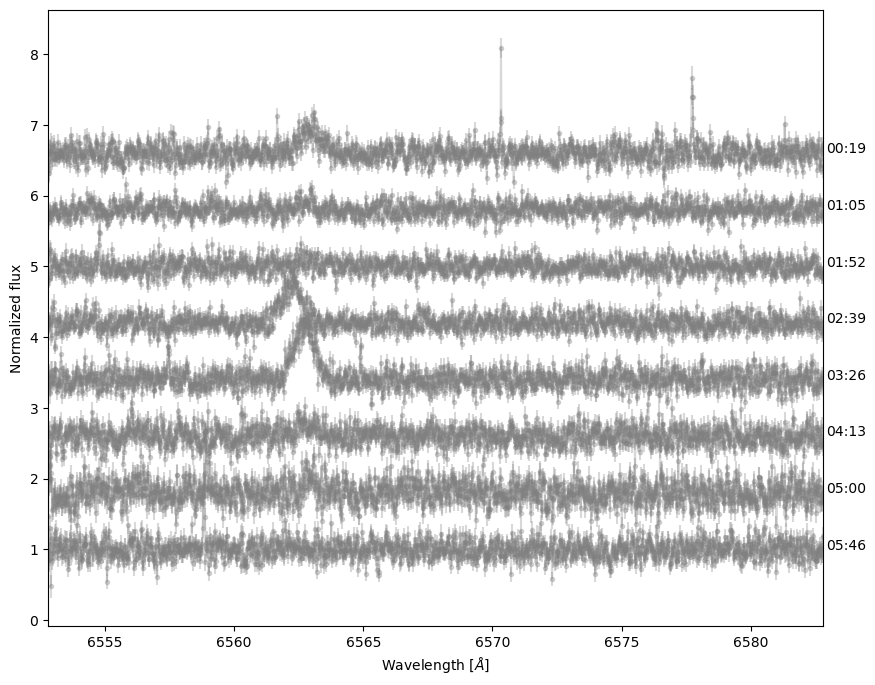

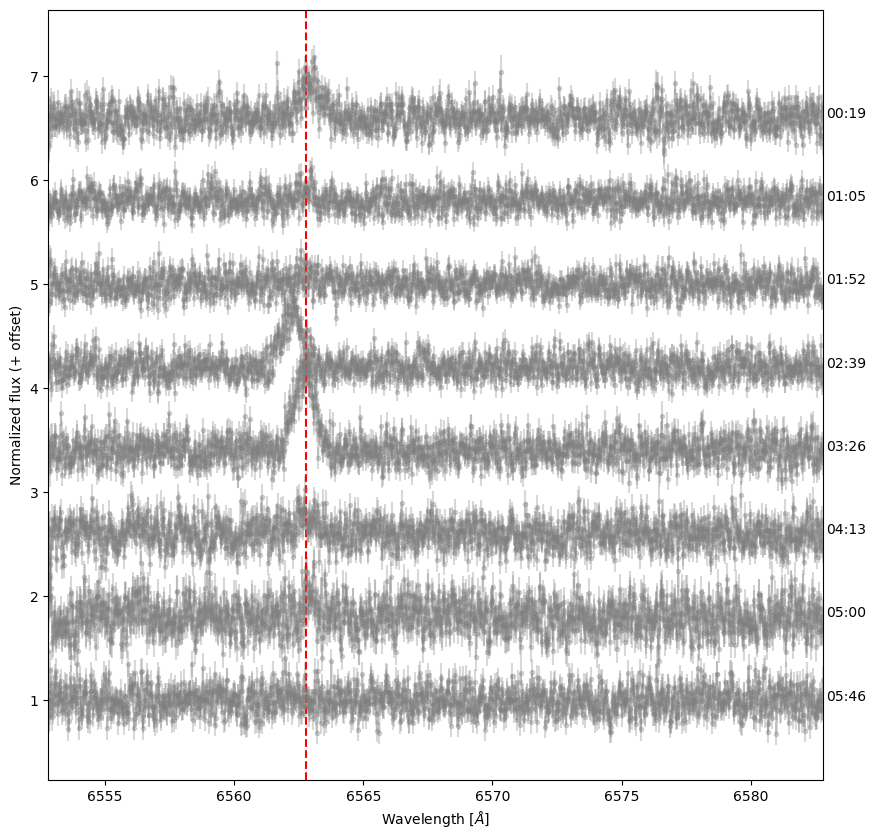

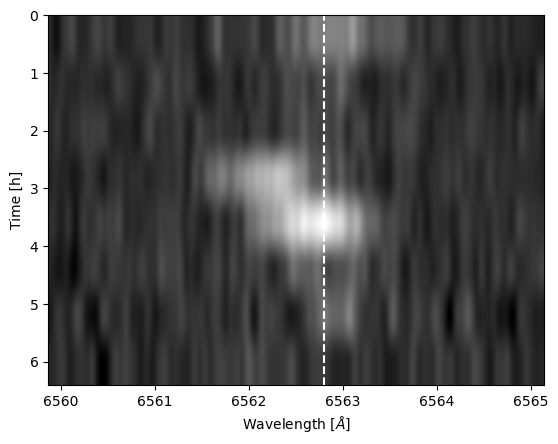